<a href="https://colab.research.google.com/github/chumdan/Machine-Learning-Project/blob/main/%ED%9A%8C%EA%B7%80/%EB%AC%B8%EC%A0%9C7_%EC%97%90%EC%96%B4%EB%B9%84%EC%97%94%EB%B9%84%EC%88%99%EB%B0%95%EB%A3%8C%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 주제 : 에어비엔비 숙박료예측 (회귀문제유형)

### Step 0. 필요패키지 설치

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC
from xgboost import XGBClassifier as XGB
from lightgbm import LGBMClassifier as LGBM
from sklearn.feature_selection import *
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras import models
from keras import layers
from sklearn.metrics import classification_report
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import plot_roc_curve

In [ ]:
# os.environ을 이용하여 Kaggle API Username, Key 세팅하기
os.environ['KAGGLE_USERNAME'] = 'chumdan'
os.environ['KAGGLE_KEY'] = '0e8bf51ba50bce898a8a9736072bd3b8'

In [ ]:
# Linux 명령어로 Kaggle API를 이용하여 데이터셋 다운로드하기 (!kaggle ~)
# Linux 명령어로 압축 해제하기
!rm *.*
!kaggle datasets download -d dgomonov/new-york-city-airbnb-open-data
!unzip '*.zip'

  0% 0.00/2.44M [00:00<?, ?B/s]
100% 2.44M/2.44M [00:00<00:00, 82.2MB/s]
Archive:  new-york-city-airbnb-open-data.zip
  inflating: AB_NYC_2019.csv         
  inflating: New_York_City_.png      


### 데이터 소개
    다음의 csv 파일을 사용한다.(스크랩핑데이터)
    - AB_NYC_2019.csv
    id: 항목의 ID
    name: 항목의 이름 (타이틀)
    host_id: 호스트 ID
    host_name: 호스트의 이름
    neighbourhood_group: 방이 있는 구역 그룹
    neighbourhood: 방이 있는 구역
    latitude: 방이 위치한 위도
    longitude: 방이 위치한 경도
    room_type: 방의 종류
    price: 가격 (미 달러)
    minimum_nights: 최소 숙박 일수
    number_of_reviews: 리뷰의 개수
    last_review: 마지막 리뷰 일자
    reviews_per_month: 월별 리뷰 개수
    calculated_host_listings_count: 호스트가 올린 방 개수
    availability_365: 365일 중 가능한 일수

    종속변수 : price 가격
    
    
- 데이터 출처: https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data

In [ ]:
df = pd.read_csv('AB_NYC_2019.csv')

### Step 1. 데이터 기초 통계 분석 및 그래프

#### 데이터프레임의 각 칼럼 분석

In [ ]:
# 불필요한 칼럼제거
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [ ]:
df['room_type'].value_counts()

Entire home/apt    25409
Private room       22326
Shared room         1160
Name: room_type, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [ ]:
df.isna().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [ ]:
(df['reviews_per_month'].isna() & df['last_review'].isna()).sum()

10052

In [ ]:
df['reviews_per_month'].isna().sum()

10052

In [ ]:
(df['number_of_reviews'] == 0).sum()
# number_of_reviews , reviews_per_month 동일한 변수

10052

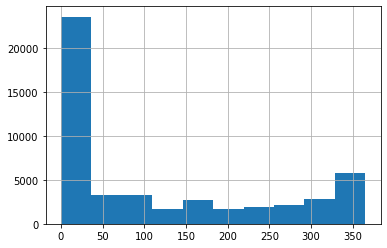

In [ ]:
df['availability_365'].hist()

In [ ]:
(df['availability_365'] == 0).sum()

17533

In [ ]:
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [ ]:
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [ ]:
df.drop(['id', 'name', 'host_name', 'latitude', 'longitude'], axis=1, inplace=True)

In [ ]:
df.head()

,host_id,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2787,Brooklyn,Kensington,Private room,149,1,9,2018-10-19,0.21,6,365
1,2845,Manhattan,Midtown,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,4632,Manhattan,Harlem,Private room,150,3,0,NaN,NaN,1,365
3,4869,Brooklyn,Clinton Hill,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,7192,Manhattan,East Harlem,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


#### 수치형 데이터와 종속변수 분석

In [ ]:
df.columns

Index(['host_id', 'neighbourhood_group', 'neighbourhood', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

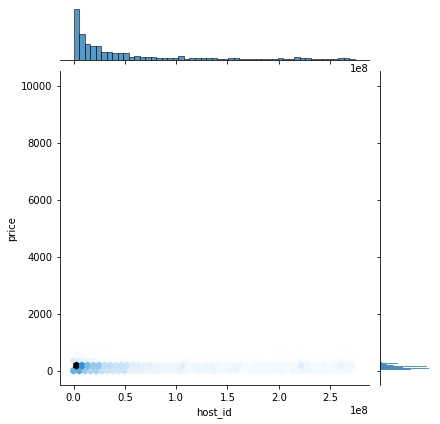

In [ ]:
# 이상치로 분석 어려움.
sns.jointplot(x='host_id', y='price', data=df, kind='hex')

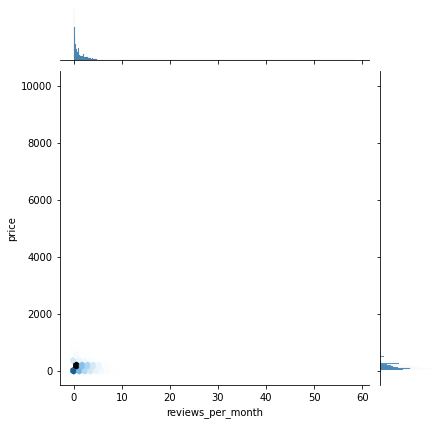

In [ ]:
# 이상치로 분석 어려움.
sns.jointplot(x='reviews_per_month', y='price', data=df, kind='hex')

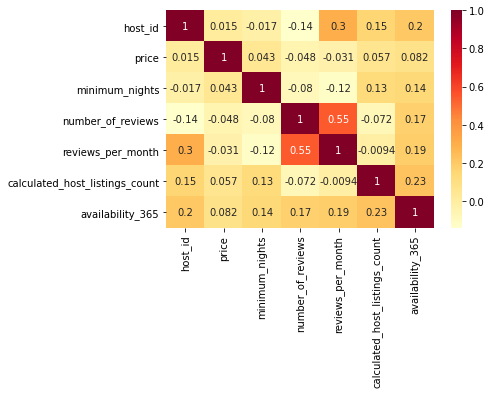

In [ ]:
sns.heatmap(df.corr(), annot=True, cmap='YlOrRd')

#### 범주형 데이터와 종속변수 관계파악

In [ ]:
df.columns

Index(['host_id', 'neighbourhood_group', 'neighbourhood', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

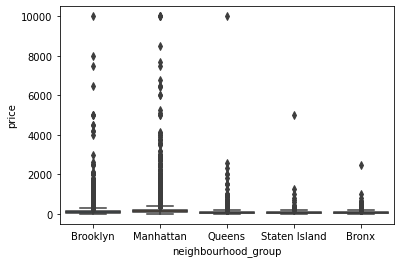

In [ ]:
sns.boxplot(x='neighbourhood_group', y='price', data=df)

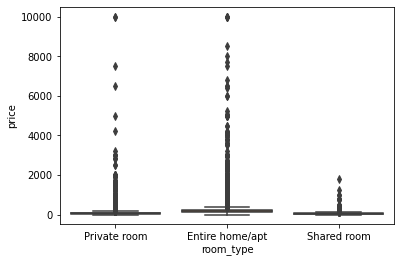

In [ ]:
sns.boxplot(x='room_type', y='price', data=df)
# 범주형 변수와 수치형 변수 모두 이상치 때문에 그래프 분석이 어려움. 데이터 클리닝 수행

### Step 2. 데이터 클리닝 수행하기

#### 미기입, 오기입 데이터 확인

In [ ]:
df.columns

Index(['host_id', 'neighbourhood_group', 'neighbourhood', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [ ]:
df.isna().sum()

host_id                               0
neighbourhood_group                   0
neighbourhood                         0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [ ]:
df['neighbourhood_group'].value_counts()

Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: neighbourhood_group, dtype: int64

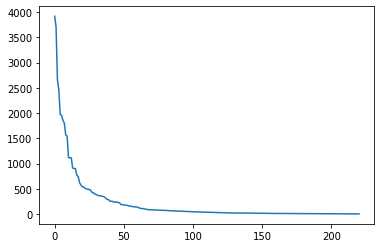

In [ ]:
# 50을 기준으로 기타분류
neigh = df['neighbourhood'].value_counts()
plt.plot(range(len(neigh)), neigh)

In [ ]:
df['neighbourhood'] = df['neighbourhood'].apply(lambda s: s if str(s) not in neigh[50:] else 'others')

In [ ]:
df['neighbourhood'].value_counts()

others                       6248
Williamsburg                 3920
Bedford-Stuyvesant           3714
Harlem                       2658
Bushwick                     2465
Upper West Side              1971
Hell's Kitchen               1958
East Village                 1853
Upper East Side              1798
Crown Heights                1564
Midtown                      1545
East Harlem                  1117
Greenpoint                   1115
Chelsea                      1113
Lower East Side               911
Astoria                       900
Washington Heights            899
West Village                  768
Financial District            744
Flatbush                      621
Clinton Hill                  572
Long Island City              537
Prospect-Lefferts Gardens     535
Park Slope                    506
East Flatbush                 500
Fort Greene                   489
Murray Hill                   485
Kips Bay                      470
Flushing                      426
Ridgewood     

In [ ]:
df['room_type'].value_counts()

Entire home/apt    25409
Private room       22326
Shared room         1160
Name: room_type, dtype: int64

In [ ]:
df.columns

Index(['host_id', 'neighbourhood_group', 'neighbourhood', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

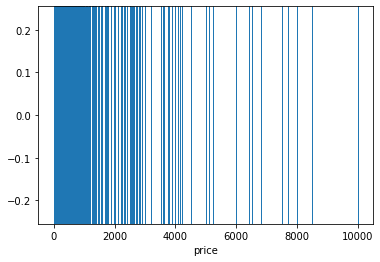

In [ ]:
sns.rugplot(x='price', data=df, height=1)

In [ ]:
print(df['price'].quantile(0.95)) # 상위 5%
print(df['price'].quantile(0.005)) # 하위 0.5%

355.0
26.0


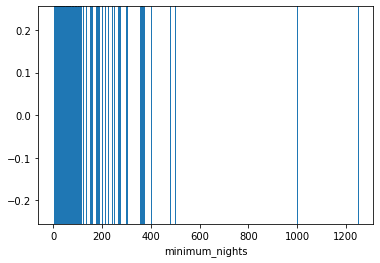

In [ ]:
sns.rugplot(x='minimum_nights', data=df, height=1)

In [ ]:
# 아웃라이어제거. 
print(df['minimum_nights'].quantile(0.98))

30.0


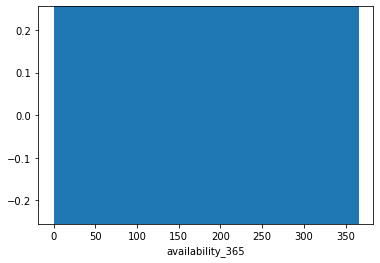

In [ ]:
sns.rugplot(x='availability_365', data=df, height=1)

In [ ]:
print(df['availability_365'].quantile(0.3))

0.0


#### 아웃라이어를 제거하고 통계 재분석

In [ ]:
p1 = df['price'].quantile(0.95)
p2 = df['price'].quantile(0.005)
print(p1, p2)

355.0 26.0


In [ ]:
df = df[(df['price'] < p1) & (df['price'] > p2)]

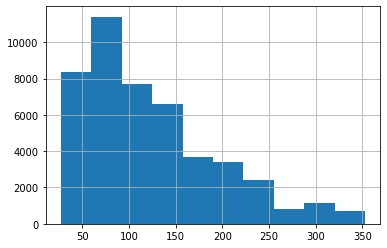

In [ ]:
# 정규분포는 아님.
df['price'].hist()

In [ ]:
mn1 = df['minimum_nights'].quantile(0.98)
print(mn1)

30.0


In [ ]:
df = df[df['minimum_nights'] < mn1]

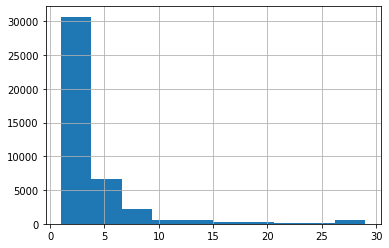

In [ ]:
df['minimum_nights'].hist()

In [ ]:
df['is_avail_zero'] = df['availability_365'].apply(lambda x: 'Zero' if x==0 else 'Nonzero')

#### 미기입 데이터 처리하기

In [ ]:
# No - 리뷰 x , Yes - 리뷰 o
df['review_exists'] = df['reviews_per_month'].isna().apply(lambda x: 'No' if x is True else 'Yes')

In [ ]:
df.fillna(0, inplace=True)

In [ ]:
df.isna().sum()

host_id                           0
neighbourhood_group               0
neighbourhood                     0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
is_avail_zero                     0
review_exists                     0
dtype: int64

In [ ]:
df.head()

,host_id,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,is_avail_zero,review_exists
0,2787,Brooklyn,others,Private room,149,1,9,2018-10-19,0.21,6,365,Nonzero,Yes
1,2845,Manhattan,Midtown,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,Nonzero,Yes
2,4632,Manhattan,Harlem,Private room,150,3,0,0,0.00,1,365,Nonzero,No
3,4869,Brooklyn,Clinton Hill,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,Nonzero,Yes
4,7192,Manhattan,East Harlem,Entire home/apt,80,10,9,2018-11-19,0.10,1,0,Zero,Yes


### Step 3. 모델 학습을 위한 전처리

#### get_dummies를 이용한 범주형 데이터 전처리

In [ ]:
df.columns

Index(['host_id', 'neighbourhood_group', 'neighbourhood', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'is_avail_zero', 'review_exists'],
      dtype='object')

In [ ]:
X_cat = df[['neighbourhood_group', 'neighbourhood', 'room_type', 'is_avail_zero', 'review_exists']]
X_cat = pd.get_dummies(X_cat)

#### MinMaxScaler를 이용해 수치형 데이터 표준화

In [ ]:
df.columns

Index(['host_id', 'neighbourhood_group', 'neighbourhood', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'is_avail_zero', 'review_exists'],
      dtype='object')

In [ ]:
# last_review 날짜형이기 떄문에 스케일링이 안됨, 그래서 제거.
scaler = MinMaxScaler()
X_num = df.drop(['neighbourhood_group', 'neighbourhood', 'room_type', 'price', 
                 'last_review', 'is_avail_zero', 'review_exists'], axis=1)

scaler.fit(X_num)
X_scaled = scaler.transform(X_num)
X_scaled = pd.DataFrame(X_scaled, index=X_num.index, columns=X_num.columns)

X = pd.concat([X_scaled, X_cat], axis=1)
y = df['price']

In [ ]:
X.head()

,host_id,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,neighbourhood_Astoria,neighbourhood_Bedford-Stuyvesant,neighbourhood_Bushwick,neighbourhood_Carroll Gardens,neighbourhood_Chelsea,neighbourhood_Chinatown,neighbourhood_Clinton Hill,neighbourhood_Crown Heights,neighbourhood_Ditmars Steinway,neighbourhood_East Elmhurst,neighbourhood_East Flatbush,neighbourhood_East Harlem,neighbourhood_East New York,neighbourhood_East Village,neighbourhood_Elmhurst,neighbourhood_Financial District,neighbourhood_Flatbush,neighbourhood_Flushing,neighbourhood_Fort Greene,neighbourhood_Gowanus,neighbourhood_Gramercy,neighbourhood_Greenpoint,neighbourhood_Greenwich Village,neighbourhood_Harlem,neighbourhood_Hell's Kitchen,neighbourhood_Inwood,neighbourhood_Jackson Heights,neighbourhood_Jamaica,neighbourhood_Kips Bay,neighbourhood_Long Island City,neighbourhood_Lower East Side,neighbourhood_Midtown,neighbourhood_Morningside Heights,neighbourhood_Murray Hill,neighbourhood_Nolita,neighbourhood_Park Slope,neighbourhood_Prospect Heights,neighbourhood_Prospect-Lefferts Gardens,neighbourhood_Ridgewood,neighbourhood_SoHo,neighbourhood_South Slope,neighbourhood_Sunnyside,neighbourhood_Sunset Park,neighbourhood_Theater District,neighbourhood_Upper East Side,neighbourhood_Upper West Side,neighbourhood_Washington Heights,neighbourhood_West Village,neighbourhood_Williamsburg,neighbourhood_Woodside,neighbourhood_others,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,is_avail_zero_Nonzero,is_avail_zero_Zero,review_exists_No,review_exists_Yes
0,7.874052e-07,0.000000,0.014308,0.003590,0.015337,1.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1
1,9.988381e-07,0.000000,0.071542,0.006496,0.003067,0.972603,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1
2,7.513158e-06,0.071429,0.000000,0.000000,0.000000,1.000000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
3,8.377116e-06,0.000000,0.429253,0.079316,0.000000,0.531507,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1
4,1.684537e-05,0.321429,0.014308,0.001709,0.000000,0.000000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1


#### 학습데이터와 테스트데이터 분리

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#### PCA를 이용해 데이터 전처리 수행하기

In [ ]:
X.shape

(41980, 69)

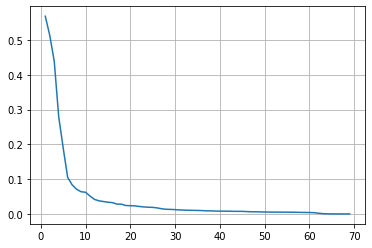

In [ ]:
pca = PCA()
pca.fit(X_train)
plt.plot(range(1, len(pca.explained_variance_) + 1), pca.explained_variance_)
plt.grid()

In [ ]:
# 20에서 끊어준다.
pca = PCA(n_components=20)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

### Step 4. Regression 모델 학습하기(y : 회귀유형)

-  데이터가 크기 때문에 LGBM만 하이퍼파라미터 조절을 통해 분석해본다.

In [ ]:
from lightgbm import LGBMRegressor as LGBM_R
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from math import sqrt

### 파라미터 그리드 설계

In [ ]:
# 모델 파라미터 그리드 설계
# 키가 모델의 함수, 값이 파라미터 그리드의 값
param_grid = dict() 

param_grid_for_LGBM_R = ParameterGrid({"max_depth": [2, 3, 4],
                                      "n_estimators": [50, 100],
                                      "learning_rate": [0.05, 0.1, 0.15, 0.2]})

param_grid[LGBM_R] = param_grid_for_LGBM_R


# 출력을 위한 max_iter_num 계산 
                            
# 튜닝 시작
best_score = 9999999999 
iteration_num = 0    
for k in range(30, 5, -1): 
    print(k)
  
    for model_func in [LGBM_R]:
        for param in param_grid[model_func]:
            model = model_func(**param).fit(pca.transform(X_train), y_train)
            y_pred = model.predict(pca.transform(X_test))
            score = MAE(y_test, y_pred)
            if score < best_score:
                best_model_func = model_func
                best_score = score
                best_parameter = param
            iteration_num += 1      


print("모델:", best_model_func)
print("점수:", best_score)
print("파라미터:", best_parameter)     

30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
모델: <class 'lightgbm.sklearn.LGBMRegressor'>
점수: 35.394642106169854
파라미터: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 100}


In [ ]:
final_model_lgbm = LGBM_R(max_depth=4, n_estimators=100,learning_rate=0.2)
final_model_lgbm.fit(pca.transform(X_train), y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.2, max_depth=4,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
pred = final_model_lgbm.predict(pca.transform(X_test))
print(MAE(y_test, pred))
print(sqrt(MSE(y_test, pred)))

35.394642106169854
49.585346205657004


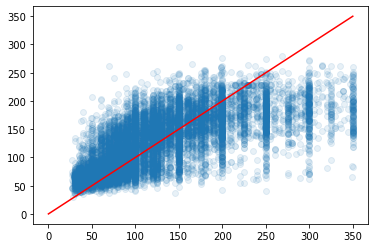

In [ ]:
plt.scatter(x=y_test, y=pred, alpha=0.1)
plt.plot([0,350], [0, 350], 'r-')

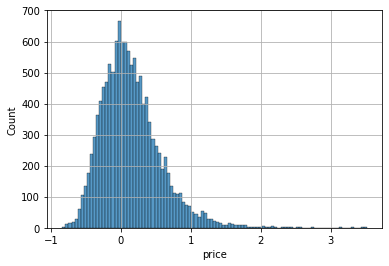

In [ ]:
err = (pred - y_test) / y_test
sns.histplot(err)
plt.grid()

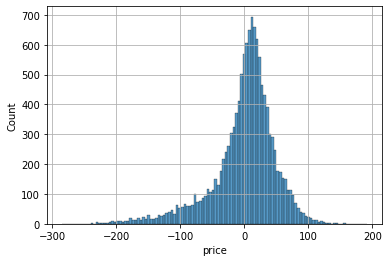

In [ ]:
err = pred - y_test
sns.histplot(err)
plt.grid()
# 전반적으로 값을 낮춰서 예측하는 경향이 있음.

#### 에러 값의 히스토그램 확인하기

### Step 5. 딥러닝.신경망 모델로 분석

In [ ]:
from keras.optimizers import Adam

In [ ]:
print(X_train.shape, y_train.shape)

(29386, 30) (29386,)


In [ ]:
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [ ]:
X_train.shape

(29386, 20)

#### 모델구현

In [ ]:
    model = models.Sequential()
    model.add(layers.Dense(16, activation='relu',input_shape=(20,)))
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(1))
    model.compile(optimizer='Adam', loss='mse', metrics=['mae'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                336       
_________________________________________________________________
batch_normalization (BatchNo (None, 16)                64        
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
batch_normalization_2 (Batch (None, 16)                64        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1

In [ ]:
# 콜백 함수 적용 부분(분류모델은 val_loss로)
early_stopping_callback = EarlyStopping(monitor='loss', mode='min', patience=10)
# 분류모델이면 model_checkpoint = ModelCheckpoint(filepath='./{epoch}-{val_loss:.2f}-{val_accuracy:.2f}.h5', monitor='val_loss', save_best_only=True, verbose=1)
model_checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/practice/분류문제/문제7_딥러닝파라미터/{epoch}-{loss:.2f}.h5', 
                                   monitor='loss', save_best_only=True, verbose=1)


history = model.fit(X_train, y_train, batch_size=16,  epochs=300,
            callbacks=[early_stopping_callback, model_checkpoint],
            validation_data=(X_test, y_test))

Epoch 1/300
1837/1837 [==============================] - 10s 4ms/step - loss: 15978.8407 - mae: 109.1525 - val_loss: 4325.8940 - val_mae: 48.1171

Epoch 00001: loss improved from inf to 11896.66113, saving model to /content/drive/MyDrive/Colab Notebooks/practice/분류문제/문제7_딥러닝파라미터/1-11896.66.h5
Epoch 2/300
1837/1837 [==============================] - 8s 4ms/step - loss: 3368.3202 - mae: 41.2158 - val_loss: 2630.0913 - val_mae: 36.7074

Epoch 00002: loss improved from 11896.66113 to 3042.00049, saving model to /content/drive/MyDrive/Colab Notebooks/practice/분류문제/문제7_딥러닝파라미터/2-3042.00.h5
Epoch 3/300
1837/1837 [==============================] - 8s 4ms/step - loss: 2753.2454 - mae: 38.1069 - val_loss: 2594.5122 - val_mae: 36.7751

Epoch 00003: loss improved from 3042.00049 to 2753.59155, saving model to /content/drive/MyDrive/Colab Notebooks/practice/분류문제/문제7_딥러닝파라미터/3-2753.59.h5
Epoch 4/300
1837/1837 [==============================] - 7s

In [ ]:
print(sqrt(2691))

51.87484939737175


#### 딥러닝 모델평가

In [ ]:
model.evaluate(X_test, y_test)

394/394 [==============================] - 1s 2ms/step - loss: 2569.9810 - mae: 36.3245


[2569.98095703125, 36.324520111083984]

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

In [ ]:
print(model.predict(X_test[5:10]))
print(y_test[5:10])

[[ 97.08649 ]
 [ 47.297764]
 [140.24034 ]
 [135.62596 ]
 [ 75.56027 ]]
2518     125
35531     50
9401     125
6643     150
28740     85
Name: price, dtype: int64


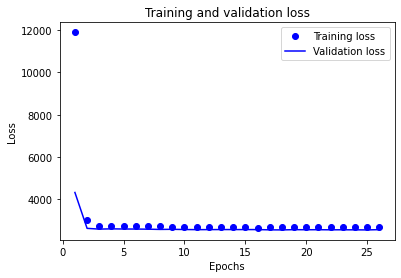

In [ ]:
loss = history.history['loss'] 
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

# ‘bo’는 파란색 점을 의미합니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# ‘b’는 파란색 실선을 의미합니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

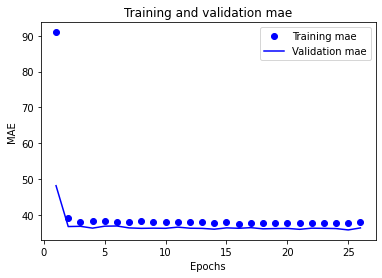

In [ ]:
plt.clf()   # 그래프를 초기화합니다
mae = history.history['mae'] 
val_mae = history.history['val_mae'] 

plt.plot(epochs, mae, 'bo', label='Training mae')
plt.plot(epochs, val_mae, 'b', label='Validation mae')
plt.title('Training and validation mae')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()